# Homework: predicting C$_2$H$_2$ and C$_2$ energy levels 

## C$_2$H$_2$

 From the [Marvel website](http://kkrk.chem.elte.hu/marvelonline/data_files/C2H2_energylevels_2019-03-20.txt) download the moelcule's states file. The file contains 7 vibrational quantum numbers (v1, v2, v3, v4, v5, l4, l5), two rotational numbers (k, J), and some symmetry numbers (ef, op, u/g and symm). Remove the states with -1, as they indicate unknown levels. 


| v1 | v2 | v3 | v4 | l4 | v5 | l5 | k | J | ef | op    | Energy     | Unc      | NumTrans | u/g | Sym            |
|----|----|----|----|----|----|----|---|---|----|-------|------------|----------|----------|-----|----------------|
| 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0 | 1 | e  | ortho | 2.353286   | 0.000000 | 204      | g   | sigma_g_plus  |
| 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0 | 3 | e  | ortho | 14.119512  | 0.000041 | 289      | g   | sigma_g_plus  |



| Column          | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `v1, v2, v3, v4, l4, v5, l5` | Quantum numbers representing vibrational or rotational states.       |
| `k`              | Likely a rotational quantum number.                                         |
| `J`              | Total angular momentum quantum number.                                      |
| `ef`             | Parity (e or f) or electronic state.                                        |
| `op`             | Symmetry or spin designation (e.g., ortho/para).                            |
| `Energy`         | Energy of the state in arbitrary units (often cm⁻¹ or eV).                  |
| `Unc`            | Uncertainty in the energy value.                                            |
| `NumTrans`       | Number of transitions involving this state.                                 |
| `u/g`            | Symmetry under inversion (ungerade = u, gerade = g).                        |
| `Sym`            | Full symmetry label, such as irreducible representation of the state.       |

[MARVEL website for C2H2](http://kkrk.chem.elte.hu/marvelonline/getdata.php?molid=8&isotopid=21)


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np 

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 1.26.4
Pandas version: 1.5.3


Start by handling the data from the file and turning it into a pandas dataframe, to eliminate uncertain states. 

In [4]:
# read the dataset file
df = pd.read_csv('C2H2_energylevels.txt', sep=r'\s+', engine='python')

# remove rows of the dataset
df = df.drop(['Unc', 'NumTrans'], axis=1)

# rearange the columns so that the energy is the last column 
df = df[[col for col in df.columns if col != 'Energy'] + ['Energy']]

# add a numerical label to each of the symmetry labels
df['ef'] = pd.factorize(df['ef'])[0]
df['op'] = pd.factorize(df['op'])[0]
df['u/g'] = pd.factorize(df['u/g'])[0]
codes, sym_labs = pd.factorize(df['Sym'])
df['Sym'] = pd.factorize(df['Sym'])[0]


# check if there are -1 in the quantum numbers and delete the rows
columns_to_check = ['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5']
df = df[~df[columns_to_check].isin([-1]).any(axis=1)]

df

,v1,v2,v3,v4,l4,v5,l5,k,J,ef,op,u/g,Sym,Energy
0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.353286
1,0,0,0,0,0,0,0,0,3,0,0,0,0,14.119512
2,0,0,0,0,0,0,0,0,5,0,0,0,0,35.297925
3,0,0,0,0,0,0,0,0,7,0,0,0,0,65.887099
4,0,0,0,0,0,0,0,0,9,0,0,0,0,105.885007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11208,3,0,1,0,0,0,0,0,31,0,1,1,4,14172.875479
11209,2,2,1,0,0,0,0,0,21,0,1,1,4,14243.079656
11210,3,0,1,0,0,0,0,0,33,0,1,1,4,14321.985812
11211,2,2,1,0,0,0,0,0,23,0,1,1,4,14346.088023


### 1.1. Build two models of your choice for predicting the states, using the vibrational and rotational numbers. Try to reach the chemical accuracy (~1 kcal/mol or ~0.05 eV).

In this case, we remove the symmetry quantum numbers and the uncertainty, leaving as features only the vibrational and rotational quantum numbers. The target of this model is to predict the energy. We indicate the features, and the target and separate the features and targets in two different datasets. 

In [7]:
features = ["v1", "v2", "v3", "v4", "l4", "v5", "l5", "k", "J"]
target = "Energy"

# we separate the dataset
X = df[features]
y = df[target]

# we generate the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1.1.1 Kernel model with only vibrational and rotational quantum numbers

A kernel model is able to perform regression by implicity mapping data to a higher dimesional space, and is able to estimate the value of a point based on the weighted combination of similarities to other points in the dataset. In this case the kernel used is the radial basis function (rbf).

This is imported from the sklearn library.

In [9]:
from sklearn.kernel_ridge import KernelRidge
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Kernel Ridge Regression model
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)  # 'rbf' kernel for non-linearity
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

The performance metrics of the model such as mean absolute error, mean squared error, root mean squared error and $R^2$ can be obtained with the sklearn functions `mean_absolute_error, mean_squared_error, r2_score`.

In [11]:
# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Kernel Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Kernel Ridge Regression Metrics:
Mean Absolute Error (MAE): 142.2962
Mean Squared Error (MSE): 48228.3108
Root Mean Squared Error (RMSE): 219.6095
R-squared (R²): 0.9934


#### 1.1.2 Random Forest with only vibrational and rotational quantum numbers

As the objective is to generate a model that performs regression, a random forest regressor will be used. A random forest model performs regression by combining predictions from multiple decision trees, each trained on random subsets of the data. It estimates the value of a point by averaging the outputs of these trees. 

This is imported from the sklearn library. The model is trained with 100 estimators and fit to the training sets. 

In [13]:
# Train a random forest regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# model predictions
y_pred = model.predict(X_test)

The performance metrics of the model such as mean absolute error, mean squared error, root mean squared error and $R^2$ can be obtained with the sklearn functions `mean_absolute_error, mean_squared_error, r2_score`.

In [15]:
# performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 24.7488
Mean Squared Error (MSE): 3129.1619
Root Mean Squared Error (RMSE): 55.9389
R-squared (R²): 0.9996


#### 1.1.3 Model comparison without symmetry quantum numbers
The model performance metrics are collected in the following table:

| Performance metric | Kernel ridge regression | Random Forest |
|- |- |- | 
|Mean Absolute Error | $ 142.2962$ | $24.7488$|
|Mean Squared Error| $ 48228.3108$ |$3129.1619$ |
|Root Mean Squared Error | $219.6095$ | $55.9389$ |
|$R^2$|$0.9934$ | $0.9996$ |

Here it can be seen that the random forest model outperforms in every performance metric to the kernel ridge regression. This is expected, due to how the two different models work. 

Kernel ridge regression relies on a predefined kernel to capture nonlinear interactions between features. As a result, if the kernel is not carefully tuned to the specific data being analyzed, the model's accuracy may be poor. 

In contrast, random forest is more flexible because it does not make strong assumptions about the data, unlike kernel-based models. The ensemble of random trees effectively captures complex, nonlinear feature interactions, leading to more accurate predictions.

### 1.2 Perform the same task adding the symmetry quantum numbers. How do the results change?
In this case now the symmetry quantum numbers are added to the features. Due to the symmetry quantum numbers being strings, a numeric label is assigned to each unique identifier, in order for the models to be able to handle the data. 

In [18]:
features = ["v1", "v2", "v3", "v4", "l4", "v5", "l5", "k", "J", "ef", "op", "u/g", "Sym"]
target = "Energy"

# we separate the dataset
X = df[features]
y = df[target]

# we generate the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1.1.1 Kernel model with symmetry quantum numbers

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Kernel Ridge Regression model
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)  # 'rbf' kernel for non-linearity
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Kernel Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Kernel Ridge Regression Metrics:
Mean Absolute Error (MAE): 176.6851
Mean Squared Error (MSE): 70407.4870
Root Mean Squared Error (RMSE): 265.3441
R-squared (R²): 0.9904


#### 1.1.2 Random Forest with symmetry quantum numbers

In [22]:
# Train a random forest regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# model predictions
y_pred = model.predict(X_test)

In [23]:
# performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 28.4275
Mean Squared Error (MSE): 3683.5909
Root Mean Squared Error (RMSE): 60.6926
R-squared (R²): 0.9995


#### 1.1.3 Model comparison with symmetry quantum numbers
The model performance metrics are collected in the following table:

| Performance metric | Kernel ridge regression (No sym.)| Random Forest (No sym.)| Kernel ridge regression (with sym.)| Random Forest (with sym.) |
|- |- |- | -| - |
|Mean Absolute Error | $ 142.2962$ | $24.7488$| $176.6851$ | $28.4275$ |
|Mean Squared Error| $ 48228.3108$ |$3129.1619$ | $70407.4870$ | $3683.5909$ |
|Root Mean Squared Error | $219.6095$ | $55.9389$ | $265.3441$ | $60.6926$ |
|$R^2$|$0.9934$ | $0.9996$ | $0.9904$ | $0.9995$ |

Again here it can be seen that random forest outperforms kernel ridge regression. 

Also, it can be seen that the inclusion of the symmetry quantum numbers to the model decreases the performance metrics in both models. This implies that treating the symmetry by assigning arbitrarily numerical labels is not the correct way to implement this information for the models. Furthermonre, it will not present valuable information for the model to estimate the energy, and the inclusion of this features results in underfitting. 

### 1.3 Is it possible to clusterise the states based on their symmetries?
To determine this, it is possible to perform a k-means fitting, in order to group all data points in $K$ different clusters maximizing the similarity between data points and distance between cluster centroids. 

In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the data by scaling features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Select number of clusters
n_clusters = 5 

# K-means fit
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Get labels for each element
labels = kmeans.labels_

# Add labels to original DataFrame
df['Cluster'] = labels

# Get centroids
print("Cluster Centers (Centroids):\n", kmeans.cluster_centers_)

Cluster Centers (Centroids):
 [[-0.34268722 -0.24189203  1.23561276  0.06322236 -0.04190475 -0.55738306
  -0.55423473 -0.61062669 -0.08721501 -0.16315478  0.02243845  0.51406443
  -0.10977225  0.48923607]
 [-0.41862975 -0.26523459 -0.22804666  0.65450785  1.15604981 -0.02119259
   0.17063507  1.27184892  0.10503831  0.24544458 -0.01367232  0.06510973
   1.3635019  -0.54612034]
 [-0.41533219 -0.30614934 -0.55764937 -0.0597309  -0.26111231 -0.02405251
  -0.17313413 -0.42590687  0.31269655 -0.12228037 -0.01919468 -0.688325
  -0.79687821 -0.94508152]
 [ 1.63901757 -0.35357324 -0.29091139 -0.3675706  -0.3865351  -0.16638664
   0.30548071 -0.05182138 -0.2205035   0.0821422   0.01828461 -0.01941051
  -0.24521528  0.72950461]
 [-0.22780137  1.64541518 -0.39086775 -0.44558468 -0.62031327  1.13756265
   0.53698039 -0.03501446 -0.23114388  0.01557862 -0.00844389  0.21579008
  -0.12325852  0.57952017]]


It is possible to visualize how the clustering was performed by representing the symmetry and the energies and the cluster to which each point belongs:

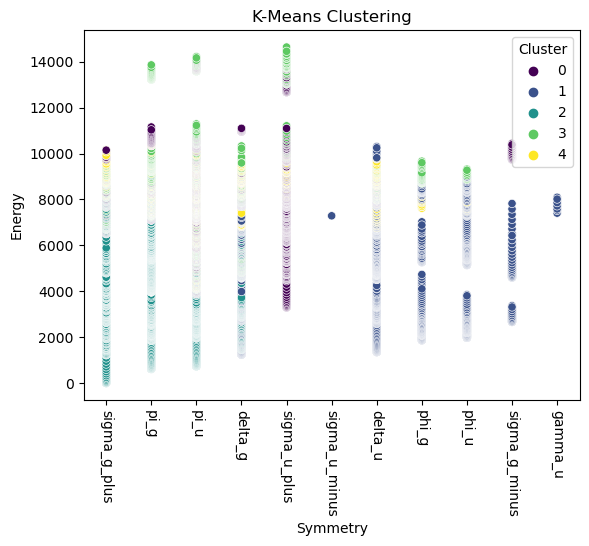

In [28]:
# Plotting
sns.scatterplot(x=df['Sym'], y=df['Energy'], hue=df['Cluster'], palette='viridis')
plt.xticks([i for i in range(11)], sym_labs, rotation=-90)
plt.title('K-Means Clustering')
plt.xlabel('Symmetry')
plt.ylabel('Energy')
plt.show()

Even though this figure shows different clusters that group distinct points, these clusters do not actually represent anything meaningful. This is because, when handling the symmetry labels for the K-means algorithm, arbitrary numbers are assigned to each symmetry state. In this case, integers from 0 to 11 are used for each symmetry state.

The values assigned by the K-means algorithm to the symmetry labels do not represent true proximity between symmetry states. For example, two points with symmetries 0 and 11 are not necessarily further apart than two points with symmetries 1 and 2. It is only possible to determine that points are close along that axis if they share the same symmetry label.

As a result of the arbitrary label assignment, if the labeling order were different, the clustering result would also change. Therfore, the proximity in this representation does not provide valuable information, as it is not possible to cluster states based on their symmetry.

## C$_2$
From the [ExoMol website](https:www.exomol.com), download the states file for [$^{12}$C$_2$](https://exomol.com/db/C2/12C2/8states/12C2__8states.states.bz2) and [$^{13}$C$_2$](https://exomol.com/db/C2/13C2/8states/13C2__8states.states.bz2). 



| Index | Energy      | $g_\mathrm{tot}$  | $J$ | Unc   | $\tau$        | $g$    | $\pm$ | ef | State         | v | $\Lambda$ | $\Sigma$ | $\Omega$ | F$_{sym}$ | idx | src    | E$_{calc}$    |
|-------|-------------|-----|-----|----------|------------|--------|-----|----|---------------|-----|-----|-----|-----|----------|-----|--------|-------------|
| 1     | 0.000000    | 1   | 0   | 0.009813 | Inf        | 0.0000 | +   | e  | X(1SIGMA+g)   | 0   | 0   | 0   | 0   | F1       | 0   | d      | 0.000000    |
| 2     | 1827.487599 | 1   | 0   | 0.000900 | 1.7058E+03 | 0.0000 | +   | e  | X(1SIGMA+g)   | 1   | 0   | 0   | 0   | F1       | 0   | m      | 1827.480518 |


"**NB:** The ExoMol states file is in the following format. (Old format, see the [most recent paper](https://doi.org/10.48550/arXiv.2406.06347) for the formatting of more recent data.
| Field                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `i`                    | State ID                                                                    |
| $\tilde{E}$            | Recommended state energy in $\\mathrm{cm^{-1}}$                            |
| $g_\mathrm{tot}$       | State degeneracy                                                            |
| $J$                    | Total angular momentum quantum number, $J$ or $F$ (integer/half-integer)    |
| Unc                    | Uncertainty in the state energy in $\\mathrm{cm^{-1}}$                       |
| $\tau$                 | State lifetime (aggregated radiative and predissociative lifetimes) in s    |
| $g$                  | Landé $g$-factor (optional)                                                 |
| QN                   | State quantum numbers, may be several columns (optional)                    |



[ExoMol website for C2.](https://exomol.com/data/molecules/C2/12C2/8states/)


### 1. Predict the molecular constants for the $X(^1\Sigma_g^+)$ and the $b(^3\Sigma^-_g)$. Compare the constants obtained for $^{12}C_2$ with the ones available from the [NIST database](https://webbook.nist.gov/cgi/inchi?ID=C12070154&Mask=1000#Diatomic).

As in the hands on, the energy is given by the formula:
$$ E_{\text{rovib, anharmonic}}(v, J) = T_e +  \left( v + \frac{1}{2} \right) \omega_e - \left( v + \frac{1}{2} \right)^2 \omega_e x_e  + \left( B  - D_e J(J+1) \right) J(J+1) + \alpha_e J^2(J+1)^2$$

The objective is to obtain the value of the constants. For this, a Random forest regression will be performed to obtain the ...

We start by again loading the text files into pandas DataFrames and separate the states:

In [32]:
# read the dataset file
import pandas as pd 
df_c12 = pd.read_csv('12C2__8states.txt', sep=r'\s+', engine='python', names=['Energy', 'gtot', 'J', 'Unc', 'tau', 'g', 'pm', 'ef', 'State',  'v', 'Lambda', 'Sigma', 'Omega', 'sym', 'idx', 'src','Ecalc'])
df_c13 = pd.read_csv('13C2__8states.txt', sep=r'\s+', engine='python', names=['Energy', 'gtot', 'J', 'Unc', 'tau', 'g', 'pm', 'ef', 'State',  'v', 'Lambda', 'Sigma', 'Omega', 'sym', 'idx', 'src','Ecalc'])
df_c12 = df_c12.drop(columns=['gtot', 'Unc', 'tau', 'g', 'pm', 'ef', 'Lambda', 'Sigma', 'Omega', 'sym', 'idx', 'src','Ecalc'])
df_c13 = df_c13.drop(columns=['gtot', 'Unc', 'tau', 'g', 'pm', 'ef', 'Lambda', 'Sigma', 'Omega', 'sym', 'idx', 'src','Ecalc'])

df_c12_x = df_c12[df_c12['State'] == 'X(1SIGMA+g)']
df_c12_b = df_c12[df_c12['State'] == 'b(3SIGMA-g)']
df_c13_x = df_c13[df_c13['State'] == 'X(1SIGMA+g)']
df_c13_b = df_c13[df_c13['State'] == 'b(3SIGMA-g)']

We define the rovibrational energy formula as a function

In [34]:
def rovib_energy(v:int, j:int, constants: np.array) -> float:
    te_term = constants[0]
    ome_term = (v + .5) * constants[1]
    omex_term = (v + .5)**2 * constants[2]
    bd_term = (constants[3]-constants[4]*(j*(j+1)))*j*(j+1)
    alpha_term = constants[5]*j**2*(j+1)**2
    return te_term + ome_term - omex_term + bd_term + alpha_term

First, we train a random forest regression model in order to predict the energy based in the quantum numbers:

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 

We can train a random forest regression model as follows, for example for the $X(^1\Sigma_g^+)$ state:

In [38]:
X = df_c12_b[['v', 'J']].values
Y = df_c12_b['Energy'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)#,criterion="squared_error",oob_score=True,random_state=10)
rf_model.fit(X_train, Y_train)


# model predictions
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

# performance metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 233.5426
Mean Squared Error (MSE): 107866.6487
Root Mean Squared Error (RMSE): 328.4306
R-squared (R²): 0.9990


It can be seen that the random forest model obtains quite good performance metrics, with a high $R$ score and a mean absoulte error lower than 350 $cm^{-1}$, within the chemical accurracy. Also, it is possible to visualize how good is the fit by plotting the predictions against the true values. The perfect result would be that all the points were in the dashed diagonal line. 

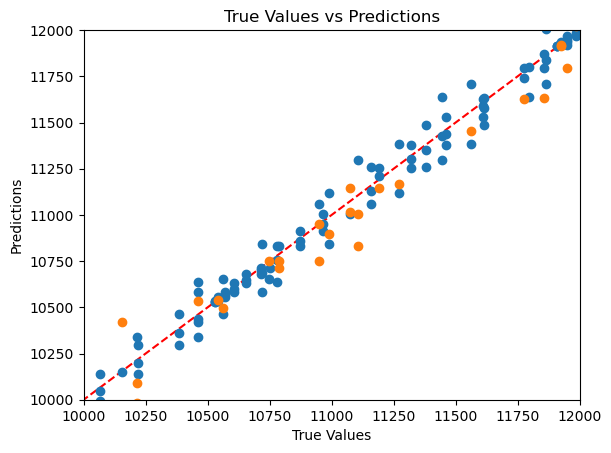

In [40]:
plt.xlim(10000,12000)
plt.ylim(10000,12000)
plt.plot([0, 24000], [0, 24000], color='red', linestyle='--')
plt.plot(Y_train, Y_pred_train,"o", label='Train set')
plt.plot(Y_test, Y_pred_test,"o", label='Test set')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

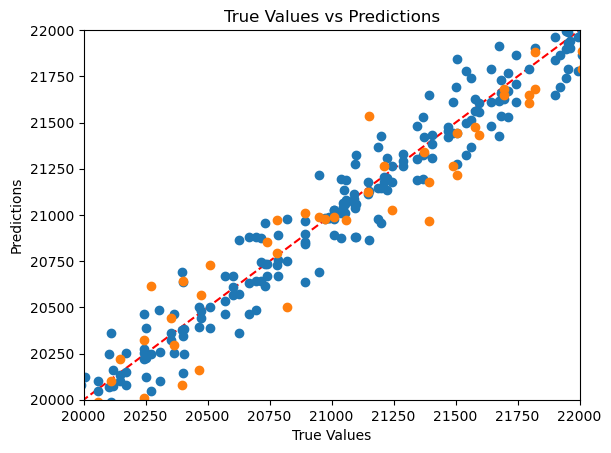

In [41]:
plt.xlim(20000,22000)
plt.ylim(20000,22000)
plt.plot([0, 24000], [0, 24000], color='red', linestyle='--')
plt.plot(Y_train, Y_pred_train,"o", label='Train set')
plt.plot(Y_test, Y_pred_test,"o", label='Test set')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

It can be seen that while the model predicts well the energy, there is some error when making predictions, that can be seen to be larger at larger energies. 

In order to extract the coefficients of the formula to compare it with tabulated data, it is possible to break down the energy formula in different contributions of the following terms:
- $(v +0.5)   · \omega_e$
- $(v +0.5)^2 · \omega_ex_e$
- $J(J+1)     · B$
- $J^2(J+1)^2 · (\alpha_e-D_e)$

Then it is possible to use this new values as features and perform a linear regression to obtain the constants. In the case of the $X(^1\Sigma_g^+)$ state:

In [43]:
X = df_c12_x[['v', 'J']].values
Y = df_c12_x['Energy'].values

true_coefficients = [0, 1854.71, 13.340, 1.8198, 0.01765, 0.00000692]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, Y_train)

y_pred_rf_est = rf_model.predict(X_test)
y_pred_rf = rf_model.predict(X_train)

# model predictions
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

# performance metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"    ")

# transform the features to the individual contributions
X_transformed = np.column_stack([
    (X_test[:, 0] + 0.5), 
    (X_test[:, 0] + 0.5) ** 2,
    (X_test[:, 1] * (X_test[:, 1] + 1)), 
    (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  
    ])
# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_transformed, y_pred_rf_est)
predicted_coefficients = linear_model.coef_

print(f"Predicted Coefficients:")
print(f"a1: {predicted_coefficients[0]}")
print(f"a2: {predicted_coefficients[1]}")
print(f"a3: {predicted_coefficients[2]}")
print(f"a4: {predicted_coefficients[3]}")
print(f"    ")

print(f"Difference in coefs /ratio")
print(f"a1: {(true_coefficients[1] - predicted_coefficients[0])/true_coefficients[1]}")
print(f"a2: {(true_coefficients[2] - np.abs(predicted_coefficients[1]))/true_coefficients[2]}")
print(f"a3: {(true_coefficients[3] - np.abs(predicted_coefficients[2]))/true_coefficients[3]}")
print(f"a4: {(true_coefficients[4] - np.abs(predicted_coefficients[3]))/true_coefficients[4]}")
print(f"    ")

Model Performance Metrics:
Mean Absolute Error (MAE): 115.7495
Mean Squared Error (MSE): 36967.0373
Root Mean Squared Error (RMSE): 192.2681
R-squared (R²): 0.9997
    
Predicted Coefficients:
a1: 1406.8325977790062
a2: -10.974651868146294
a3: 1.098899582510739
a4: 1.192138100591933e-05
    
Difference in coefs /ratio
a1: 0.24148109527688633
a2: 0.17731245366219683
a3: 0.3961426626493356
a4: 0.9993245676483898
    


Following the same procedure for the $b(^3\Sigma^-_g)$ state: 

In [45]:
X = df_c12_b[['v', 'J']].values
Y = df_c12_b['Energy'].values

true_coefficients = [6434.27, 1470.45, 11.19, 1.49852, -0.000087]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, Y_train)

y_pred_rf_est = rf_model.predict(X_test)
y_pred_rf = rf_model.predict(X_train)

# model predictions
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

# performance metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"    ")


# transform the features to the individual contributions
X_transformed = np.column_stack([
    (X_test[:, 0] + 0.5), 
    (X_test[:, 0] + 0.5) ** 2,
    (X_test[:, 1] * (X_test[:, 1] + 1)), 
    (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  
    ])
# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_transformed, y_pred_rf_est)
predicted_coefficients = linear_model.coef_

print(f"Predicted Coefficients:")
print(f"a1: {predicted_coefficients[0]}")
print(f"a2: {predicted_coefficients[1]}")
print(f"a3: {predicted_coefficients[2]}")
print(f"a4: {predicted_coefficients[3]}")
print(f"    ")

print(f"Difference in coefs /ratio")
print(f"a1: {(true_coefficients[1] - predicted_coefficients[0])/true_coefficients[1]}")
print(f"a2: {(true_coefficients[2] - np.abs(predicted_coefficients[1]))/true_coefficients[2]}")
print(f"a3: {(true_coefficients[3] - np.abs(predicted_coefficients[2]))/true_coefficients[3]}")
print(f"a4: {(true_coefficients[4] - np.abs(predicted_coefficients[3]))/true_coefficients[4]}")
print(f"    ")

Model Performance Metrics:
Mean Absolute Error (MAE): 226.4336
Mean Squared Error (MSE): 113722.8480
Root Mean Squared Error (RMSE): 337.2282
R-squared (R²): 0.9990
    
Predicted Coefficients:
a1: 1248.9249217552879
a2: -5.863671380863928
a3: 1.1790627682326074
a4: 1.4986031642294506e-06
    
Difference in coefs /ratio
a1: 0.15065121442055981
a2: 0.4759900463928572
a3: 0.21318182724781298
a4: 1.0172253237267752
    


The values of the constants obtained by the fitting and the real constants are shown in the following table in the case of the $X(^1\Sigma_g^+)$ state:

|constant| Nist | RF/LR |
|--------|------|-------|
|$\omega_e$|1406.83|1854.71|
|$\omega_ex_e$|10.97|13.34|
|$B_e$|1.09|1.82|
|$\alpha_e$|1.19e-05|0.01765|

And for the $b(^3\Sigma^-_g)$ state: 
|constant| Nist | RF/LR |
|--------|------|-------|
|$\omega_e$|1248.92|1470.45|
|$\omega_ex_e$|5.86| 11.19|
|$B_e$|1.18| 1.50|
|$\alpha_e$| 1.49e-06|1.49|

From the previous results, it can be seen that even though the random forest regression model presents good results, triying to extract directly the constant values can result in a poor descriptin of them, as in this case, with high relative error. This highlights the complexity of the random forest model and how it treats with non-linearity of data, but sometimes it can be difficult to infere how the model actually is processing the data to make predictions. 

The same procedure can be followed for the $^{13}C_2$ molecule:

In [47]:
X = df_c13_x[['v', 'J']].values
Y = df_c13_x['Energy'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, Y_train)

y_pred_rf_est = rf_model.predict(X_test)
y_pred_rf = rf_model.predict(X_train)

# model predictions
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

# performance metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"    ")


# transform the features to the individual contributions
X_transformed = np.column_stack([
    (X_test[:, 0] + 0.5), 
    (X_test[:, 0] + 0.5) ** 2,
    (X_test[:, 1] * (X_test[:, 1] + 1)), 
    (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  
    ])
# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_transformed, y_pred_rf_est)
predicted_coefficients = linear_model.coef_

print(f"Predicted Coefficients:")
print(f"a1: {predicted_coefficients[0]}")
print(f"a2: {predicted_coefficients[1]}")
print(f"a3: {predicted_coefficients[2]}")
print(f"a4: {predicted_coefficients[3]}")
print(f"    ")

Model Performance Metrics:
Mean Absolute Error (MAE): 7717.7758
Mean Squared Error (MSE): 225454792.8181
Root Mean Squared Error (RMSE): 15015.1521
R-squared (R²): 0.6984
    
Predicted Coefficients:
a1: -187.70632655065194
a2: -3.4438678641131117
a3: 0.16978458221563944
a4: -1.319548195155562e-07
    


In [48]:
X = df_c13_b[['v', 'J']].values
Y = df_c13_b['Energy'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, Y_train)

y_pred_rf_est = rf_model.predict(X_test)
y_pred_rf = rf_model.predict(X_train)

# model predictions
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

# performance metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"    ")


# transform the features to the individual contributions
X_transformed = np.column_stack([
    (X_test[:, 0] + 0.5), 
    (X_test[:, 0] + 0.5) ** 2,
    (X_test[:, 1] * (X_test[:, 1] + 1)), 
    (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  
    ])
# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_transformed, y_pred_rf_est)
predicted_coefficients = linear_model.coef_

print(f"Predicted Coefficients:")
print(f"a1: {predicted_coefficients[0]}")
print(f"a2: {predicted_coefficients[1]}")
print(f"a3: {predicted_coefficients[2]}")
print(f"a4: {predicted_coefficients[3]}")
print(f"    ")

Model Performance Metrics:
Mean Absolute Error (MAE): 7995.8694
Mean Squared Error (MSE): 234960393.5389
Root Mean Squared Error (RMSE): 15328.4178
R-squared (R²): 0.7006
    
Predicted Coefficients:
a1: -93.63456753360752
a2: -12.853850696284102
a3: 0.14830920925882693
a4: -1.019557647197189e-07
    


From these results, it can be seen that the models built are not accurrate, as they present poor performance metrics in both cases and negative constant values, which don't make physical sense.

### Use a Kernel model to reproduce the heat capacity and partition function of $^{12}C_2$.

In [50]:
df_hc = pd.read_csv('12C2__8states.cp.txt', sep=r'\s+', engine='python', names=['T', 'hc'])
df_pf = pd.read_csv('12C2__8states.pf.txt', sep=r'\s+', engine='python', names=['T', 'z'])

In [51]:
X = df_hc[['T']]
y = df_hc[['hc']]

# we generate the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.kernel_ridge import KernelRidge
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Kernel Ridge Regression model
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)  # 'rbf' kernel for non-linearity
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Kernel Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Kernel Ridge Regression Metrics:
Mean Absolute Error (MAE): 0.5289
Mean Squared Error (MSE): 1.1999
Root Mean Squared Error (RMSE): 1.0954
R-squared (R²): 0.8323


In [52]:
X = df_pf[['T']]
y = df_pf[['z']]

# we generate the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.kernel_ridge import KernelRidge
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Kernel Ridge Regression model
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)  # 'rbf' kernel for non-linearity
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Kernel Ridge Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Kernel Ridge Regression Metrics:
Mean Absolute Error (MAE): 652.3292
Mean Squared Error (MSE): 853488.7829
Root Mean Squared Error (RMSE): 923.8446
R-squared (R²): 0.9992


The result of the performance metrics for the ridge regression model in both cases is collected in the following table:
|Metric|Heat capacity|Partition function|
|-|-|-|
|MAE   | 0.5289 | 652.33|
|MSE   | 1.1999 | 853488.78|
|RMSE  | 1.0954 | 923.84|
|$R^2$ |  0.8323|  0.9992|

From this results, it can be seen that the kernel model performs adequately in the case of the partition function, but is not good at predicting the heat capacity. It can be seen that the, mean absolunte error in the heat capacity of this model is two times the difference between the smallest and largest heat capacity. Thus, the results of this model are completely unreliable. 

In the case of the partition function, the performance metrics are better, but still the MAE and RMSE suggest that there could be errors in the model, specially at low temperatures, where the partition function values are small.

# Conclusions 
In this work, machine learning was used to predict energy levels for  $C_2H_2$ and molecular constants for $C_2$ using various machine learning techniques. For $C_2H_2$, kernel ridge regression and random forest regression models were applied, with the random forest model performing better due to its ability to handle complex, non-linear data. Including symmetry as features in the regression models made them less accurate. When predicting molecular constants for $C_2$ using random forest regression, the model showed reasonable accuracy, but the extracted molecular constants had significant errors compared to the NIST database. Lastly, a kernel model was trained to predict heat capacity and the partition function for 
$C_2$, performing poorly for heat capacity but adequately for the partition function.